# Gold EDA — SRAG Metrics

This notebook explores the **Gold** layer metrics (`gold.fct_daily_uf`, `gold.fct_monthly_uf`).
It aggregates to national level when needed and produces a few simple plots.

**Notes**
- Uses DuckDB in read-only mode and pandas for DataFrames.
- Plots are Matplotlib-only and minimal.
- For national KPIs, we re-aggregate UF rows (never average UF percentages).

In [1]:
import os
from pathlib import Path
import duckdb as ddb
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

def find_project_root() -> Path:
    cur = Path.cwd()
    while cur != cur.parent and not (cur / 'pyproject.toml').exists():
        cur = cur.parent
    return cur

def resolve_db_path() -> Path:
    db_env = os.getenv('DUCKDB_PATH', 'data/srag.duckdb')
    db_path = Path(db_env)
    if not db_path.is_absolute():
        db_path = find_project_root() / db_path
    return db_path

DB_PATH = resolve_db_path()
print('Using DB:', DB_PATH)
assert DB_PATH.exists(), f'DB not found at: {DB_PATH}'

con = ddb.connect(str(DB_PATH), read_only=True)

def q(sql: str, params: dict | None = None) -> pd.DataFrame:
    return con.execute(sql, params or {}).df()


Using DB: /home/ziolli/Área de trabalho/Case-Indicium/data/srag.duckdb


## What Gold views exist?

In [2]:
q("""
SELECT table_schema, table_name
FROM information_schema.views
WHERE table_schema = 'gold'
ORDER BY 2;
""")


,table_schema,table_name
0,gold,fct_daily_uf
1,gold,fct_monthly_uf


## Daily Brazil — last 120 days

In [3]:
daily_br = q("""
WITH d AS (
  SELECT day, SUM(cases) AS cases, SUM(deaths) AS deaths
  FROM gold.fct_daily_uf
  GROUP BY day
)
SELECT * FROM d
WHERE day > CURRENT_DATE - INTERVAL 120 DAY
ORDER BY day;
""").set_index('day').sort_index()
daily_br.tail()


,cases,deaths
day,,
2025-09-04,609.0,8.0
2025-09-05,428.0,8.0
2025-09-06,76.0,3.0
2025-09-07,47.0,0.0
2025-09-08,2.0,0.0


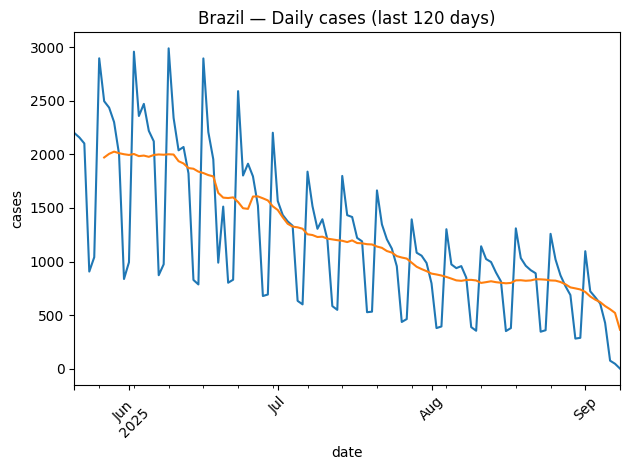

In [4]:
plt.figure()
daily_br['cases'].plot()
daily_br['cases'].rolling(7).mean().plot()
plt.title('Brazil — Daily cases (last 120 days)')
plt.xlabel('date'); plt.ylabel('cases')
plt.xticks(rotation=45); plt.tight_layout()


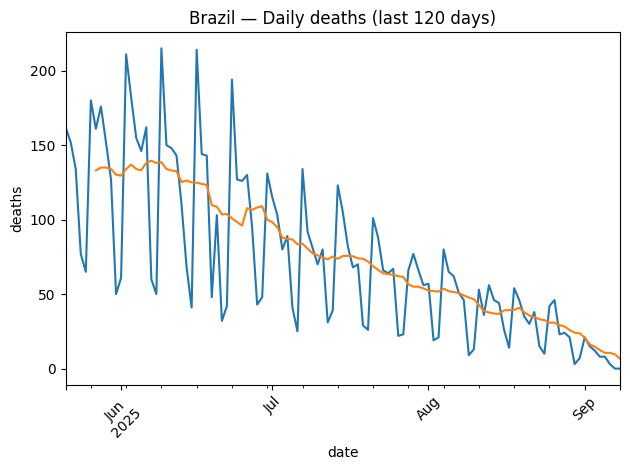

In [5]:
plt.figure()
daily_br['deaths'].plot()
daily_br['deaths'].rolling(7).mean().plot()
plt.title('Brazil — Daily deaths (last 120 days)')
plt.xlabel('date'); plt.ylabel('deaths')
plt.xticks(rotation=45); plt.tight_layout()


## KPIs (30 days) — CFR (closed cases), ICU %, Vaccinated %

In [6]:
kp = q("""
WITH agg AS (
  SELECT
    SUM(closed_cases_30d)  AS closed_cases_30d,
    SUM(deaths_30d)        AS deaths_30d,
    SUM(cases)             AS cases_30d,
    SUM(icu_cases)         AS icu_cases_30d,
    SUM(vaccinated_cases)  AS vaccinated_cases_30d
  FROM gold.fct_daily_uf
  WHERE day > CURRENT_DATE - INTERVAL 30 DAY
)
SELECT
  100.0 * deaths_30d / NULLIF(closed_cases_30d, 0) AS cfr_closed_30d_pct,
  100.0 * icu_cases_30d / NULLIF(cases_30d, 0)     AS icu_rate_30d_pct,
  100.0 * vaccinated_cases_30d / NULLIF(cases_30d, 0) AS vaccinated_rate_30d_pct
FROM agg;
""")
kp


,cfr_closed_30d_pct,icu_rate_30d_pct,vaccinated_rate_30d_pct
0,NaN,24.621496,47.121871


## Top UFs by cases (last 30 days) + CFR by UF (last 90 days)

In [7]:
top_ufs_30d = q("""
SELECT uf, SUM(cases) AS cases_30d
FROM gold.fct_daily_uf
WHERE day > CURRENT_DATE - INTERVAL 30 DAY
GROUP BY uf
ORDER BY cases_30d DESC
LIMIT 12;
""")
top_ufs_30d


,uf,cases_30d
0,SP,3101.0
1,PR,1444.0
2,MG,1238.0
3,RS,942.0
4,RJ,880.0
5,SC,715.0
6,BA,640.0
7,DF,602.0
8,GO,462.0
9,PB,423.0


In [8]:
cfr_uf_90d = q("""
WITH agg AS (
  SELECT uf,
         SUM(closed_cases_30d) AS closed_cases_30d,
         SUM(deaths_30d)       AS deaths_30d
  FROM gold.fct_daily_uf
  WHERE day > CURRENT_DATE - INTERVAL 90 DAY
  GROUP BY 1
)
SELECT uf,
       100.0 * deaths_30d / NULLIF(closed_cases_30d, 0) AS cfr_closed_30d_pct
FROM agg
ORDER BY cfr_closed_30d_pct DESC NULLS LAST
LIMIT 12;
""")
cfr_uf_90d


,uf,cfr_closed_30d_pct
0,PI,21.969697
1,GO,12.030075
2,PB,11.190053
3,ES,10.921502
4,TO,10.810811
5,AL,10.591900
6,RJ,9.953767
7,RS,9.329321
8,SP,9.012066
9,MT,8.188976


## Monthly Brazil — last 12 months

In [9]:
monthly_br = q("""
SELECT month,
       SUM(cases)  AS cases,
       SUM(deaths) AS deaths
FROM gold.fct_monthly_uf
WHERE month >= DATE_TRUNC('month', CURRENT_DATE) - INTERVAL 12 MONTH
GROUP BY month
ORDER BY month;
""").set_index('month').sort_index()
monthly_br.tail()


,cases,deaths
month,,
2025-05-01,52631.0,3548.0
2025-06-01,52237.0,3522.0
2025-07-01,35179.0,2179.0
2025-08-01,23950.0,1092.0
2025-09-01,3650.0,67.0


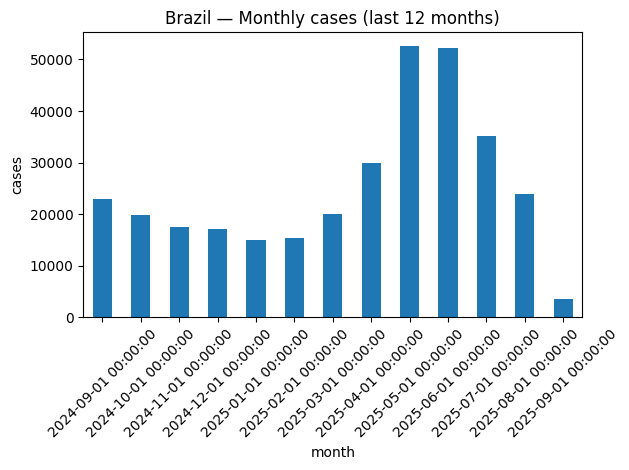

In [10]:
plt.figure()
monthly_br['cases'].plot(kind='bar')
plt.title('Brazil — Monthly cases (last 12 months)')
plt.ylabel('cases'); plt.xticks(rotation=45)
plt.tight_layout()


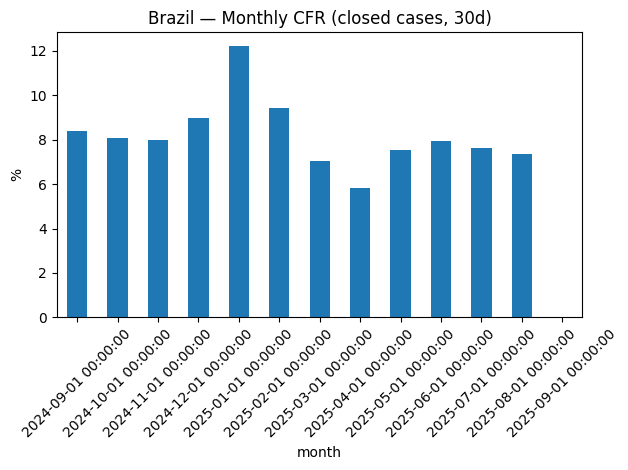

In [11]:
plt.figure()
cfr_monthly = q("""
WITH m AS (
  SELECT month,
         SUM(closed_cases_30d) AS closed_cases_30d,
         SUM(deaths_30d)       AS deaths_30d
  FROM gold.fct_monthly_uf
  WHERE month >= DATE_TRUNC('month', CURRENT_DATE) - INTERVAL 12 MONTH
  GROUP BY 1
)
SELECT month, 100.0 * deaths_30d / NULLIF(closed_cases_30d, 0) AS cfr_closed_30d_pct
FROM m
ORDER BY month;
""").set_index('month').sort_index()
cfr_monthly['cfr_closed_30d_pct'].plot(kind='bar')
plt.title('Brazil — Monthly CFR (closed cases, 30d)')
plt.ylabel('%'); plt.xticks(rotation=45)
plt.tight_layout()
